<a href="https://colab.research.google.com/github/elfkr7/Intro-to-DL/blob/main/ImageClassification_EfficientNet_ModelSelection%26Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [ ]:
! pip install -q kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [ ]:
! kaggle competitions download -c csc4851-homework4

 98% 1.28G/1.30G [00:32<00:00, 29.0MB/s]
100% 1.30G/1.30G [00:32<00:00, 42.8MB/s]


In [ ]:
!unzip csc4851-homework4.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: birds_400/train/VERMILION FLYCATHER/102.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/103.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/104.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/105.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/106.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/107.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/108.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/109.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/110.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/111.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/112.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/113.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/114.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/115.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/116.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/117.jpg  
  inflati

In [ ]:
#torch
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

#libs
import matplotlib.pyplot as plt
import os
import sys
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
species = pd.read_csv("birds_400/class_dict.csv")
species

,class_index,class,height,width,scale by,Offset
0,0,ABBOTTS BABBLER,112,112,1,0
1,1,ABBOTTS BOOBY,112,112,1,0
2,2,ABYSSINIAN GROUND HORNBILL,112,112,1,0
3,3,AFRICAN CROWNED CRANE,112,112,1,0
4,4,AFRICAN EMERALD CUCKOO,112,112,1,0
...,...,...,...,...,...,...
395,395,WILSONS BIRD OF PARADISE,112,112,1,0
396,396,WOOD DUCK,112,112,1,0
397,397,YELLOW BELLIED FLOWERPECKER,112,112,1,0
398,398,YELLOW CACIQUE,112,112,1,0


In [ ]:
classes = list(species['class'])
classes

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'AVADAVAT',
 'AZURE JAY',
 'AZURE TANAGER',
 'AZURE TIT',
 'BAIKAL TEAL',
 'BALD EAGLE',
 'BALD IBIS',
 'BALI STARLING',
 'BALTIMORE ORIOLE',
 'BANANAQUIT',
 'BAND TAILED GUAN',
 'BANDED BROADBILL',
 'BANDED PITA',
 'BANDED STILT',
 'BAR-TAILED GODWIT',
 'BARN OWL',
 'BARN SWALLOW',
 'BARRED PUFFBIRD',
 'BARROWS GOLDENEYE',
 'BAY-B

In [ ]:
#check the number of the classes
print(len(classes))

400


In [ ]:
def get_data_loaders(data_dir, batch_size=64, train = False):
    if train:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(), 
                                                        transforms.GaussianBlur(3)]), p=0.1),
            transforms.Resize(256),
            transforms.CenterCrop(240),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.RandomErasing(p=0.14, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform=transform)
        print(f"Found {len(train_data)} images for training with {len(train_data.classes)} classes")
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        return train_loader, len(train_data)
    
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(240),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "valid/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        print(f"Found {len(val_data)} images for validation with {len(val_data.classes)} classes")
        print(f"Found {len(test_data)} images for testing with {len(test_data.classes)} classes")
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)
        return (val_loader, test_loader, len(val_data), len(test_data))

In [ ]:
(train_loader, train_data_len) = get_data_loaders("birds_400", 256, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders("birds_400", 5, train=False)

Found 58388 images for training with 400 classes
Found 2000 images for validation with 400 classes
Found 2000 images for testing with 400 classes


In [ ]:
#check loader len
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))
#check dataset sizes
print(train_data_len)
print(test_data_len)
print(valid_data_len)

229
400
400
58388
2000
2000


In [ ]:
data_load= {"train":train_loader,"val": val_loader}
data_sizes = {"train":train_data_len,"val": valid_data_len}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

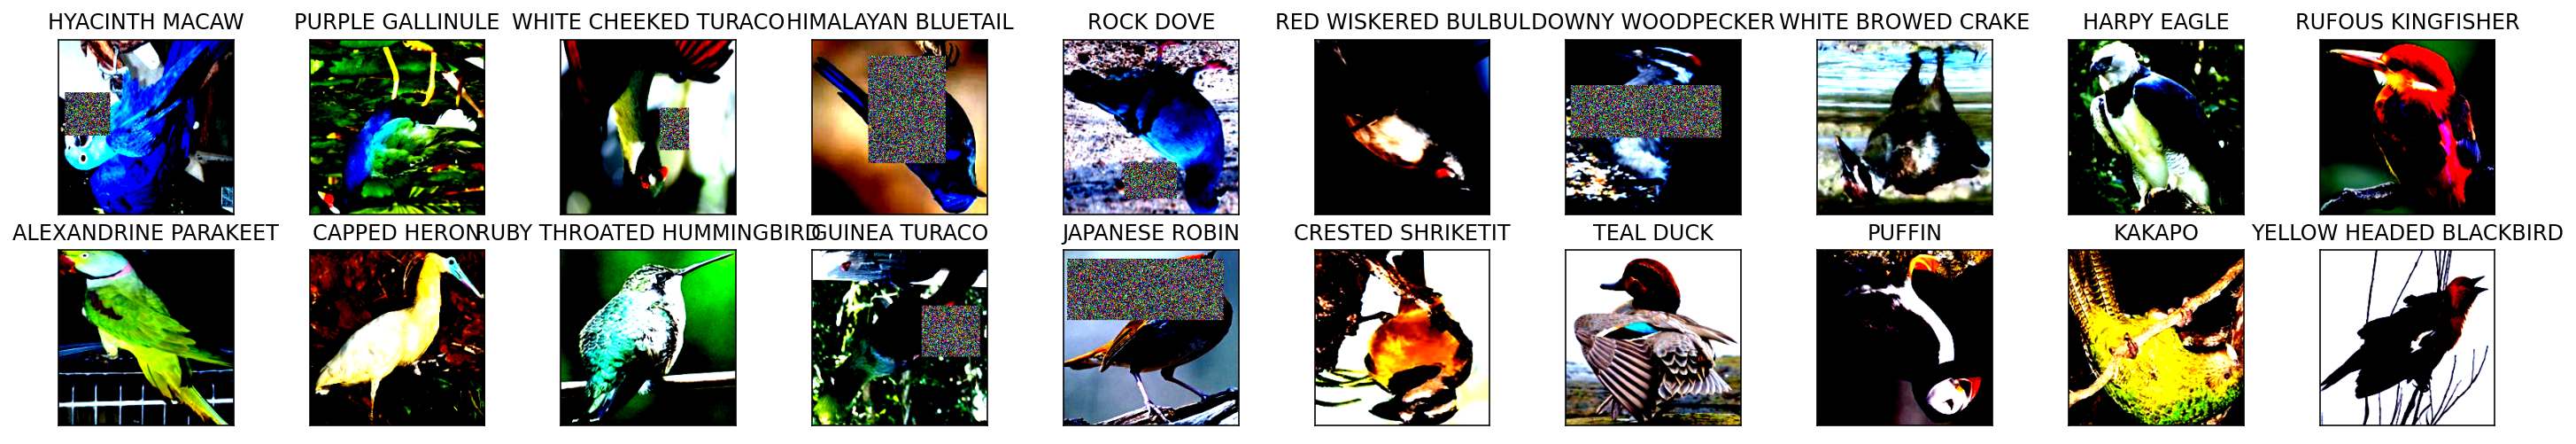

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display purposes

# plot the images in the batch
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
torch.backends.cudnn.benchmark = True
model = models.efficientnet_b1(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
n_inputs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.SiLU(),
    nn.Dropout(0.2),
    nn.Linear(2048, len(classes))
)

model = model.to(device)
print(model.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=2048, out_features=400, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = criterion.to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.01)

In [ ]:
training_hist = {'accuracy':[],'loss':[]}
validation_hist= {'accuracy':[],'loss':[]}

In [ ]:
#define scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [ ]:
import time
import copy
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(data_load[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.double() / data_sizes[phase]
            
            if phase == 'train':
                training_hist['accuracy'].append(epoch_acc)
                training_hist['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_hist['accuracy'].append(epoch_acc)
                validation_hist['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:

model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=10)

Epoch 0/9
----------



100%|██████████| 229/229 [05:48<00:00,  1.52s/it]


train Loss: 1.9085 Acc: 0.7982



100%|██████████| 400/400 [00:15<00:00, 25.39it/s]


val Loss: 1.4783 Acc: 0.9265

Epoch 1/9
----------



100%|██████████| 229/229 [05:46<00:00,  1.51s/it]


train Loss: 1.8300 Acc: 0.8219



100%|██████████| 400/400 [00:15<00:00, 25.03it/s]


val Loss: 1.4334 Acc: 0.9365

Epoch 2/9
----------



100%|██████████| 229/229 [05:45<00:00,  1.51s/it]


train Loss: 1.8002 Acc: 0.8280



100%|██████████| 400/400 [00:16<00:00, 23.98it/s]


val Loss: 1.4308 Acc: 0.9340

Epoch 3/9
----------



100%|██████████| 229/229 [05:49<00:00,  1.53s/it]


train Loss: 1.7751 Acc: 0.8357



100%|██████████| 400/400 [00:16<00:00, 24.57it/s]


val Loss: 1.4178 Acc: 0.9345

Epoch 4/9
----------



100%|██████████| 229/229 [05:53<00:00,  1.54s/it]


train Loss: 1.7433 Acc: 0.8455



100%|██████████| 400/400 [00:16<00:00, 24.45it/s]


val Loss: 1.4068 Acc: 0.9365

Epoch 5/9
----------



100%|██████████| 229/229 [05:52<00:00,  1.54s/it]


train Loss: 1.7319 Acc: 0.8483



100%|██████████| 400/400 [00:16<00:00, 24.18it/s]


val Loss: 1.4057 Acc: 0.9380

Epoch 6/9
----------



100%|██████████| 229/229 [05:49<00:00,  1.53s/it]


train Loss: 1.7154 Acc: 0.8532



100%|██████████| 400/400 [00:16<00:00, 23.55it/s]


val Loss: 1.3923 Acc: 0.9405

Epoch 7/9
----------



100%|██████████| 229/229 [05:50<00:00,  1.53s/it]


train Loss: 1.6951 Acc: 0.8620



100%|██████████| 400/400 [00:16<00:00, 23.72it/s]


val Loss: 1.3832 Acc: 0.9440

Epoch 8/9
----------



100%|██████████| 229/229 [05:51<00:00,  1.54s/it]


train Loss: 1.6904 Acc: 0.8617



100%|██████████| 400/400 [00:16<00:00, 23.75it/s]


val Loss: 1.3806 Acc: 0.9430

Epoch 9/9
----------



100%|██████████| 229/229 [05:54<00:00,  1.55s/it]


train Loss: 1.6844 Acc: 0.8643



100%|██████████| 400/400 [00:17<00:00, 23.30it/s]


val Loss: 1.3804 Acc: 0.9440

Training complete in 61m 8s
Best val Acc: 0.944000


In [ ]:
loss_per_class=[]
def test(model):
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))
  model.eval()

  for data, target in tqdm(test_loader):
      if torch.cuda.is_available(): 
          data, target = data.cuda(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
        loss_per_class.append(np.squeeze(loss.numpy()) if not torch.cuda.is_available() else np.squeeze(loss.cpu().numpy()))

      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      if len(target) == 5:
        for i in range(5):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))
  

In [ ]:
test(model_ft)


100%|██████████| 400/400 [00:17<00:00, 23.48it/s]


Test Loss: 1.364121

Test Accuracy of ABBOTTS BABBLER: 100% ( 5/ 5)
Test Accuracy of ABBOTTS BOOBY: 60% ( 3/ 5)
Test Accuracy of ABYSSINIAN GROUND HORNBILL: 100% ( 5/ 5)
Test Accuracy of AFRICAN CROWNED CRANE: 100% ( 5/ 5)
Test Accuracy of AFRICAN EMERALD CUCKOO: 100% ( 5/ 5)
Test Accuracy of AFRICAN FIREFINCH: 100% ( 5/ 5)
Test Accuracy of AFRICAN OYSTER CATCHER: 100% ( 5/ 5)
Test Accuracy of ALBATROSS: 80% ( 4/ 5)
Test Accuracy of ALBERTS TOWHEE: 100% ( 5/ 5)
Test Accuracy of ALEXANDRINE PARAKEET: 100% ( 5/ 5)
Test Accuracy of ALPINE CHOUGH: 60% ( 3/ 5)
Test Accuracy of ALTAMIRA YELLOWTHROAT: 20% ( 1/ 5)
Test Accuracy of AMERICAN AVOCET: 100% ( 5/ 5)
Test Accuracy of AMERICAN BITTERN: 100% ( 5/ 5)
Test Accuracy of AMERICAN COOT: 100% ( 5/ 5)
Test Accuracy of AMERICAN GOLDFINCH: 80% ( 4/ 5)
Test Accuracy of AMERICAN KESTREL: 100% ( 5/ 5)
Test Accuracy of AMERICAN PIPIT: 100% ( 5/ 5)
Test Accuracy of AMERICAN REDSTART: 60% ( 3/ 5)
Test Accuracy of AMETHYST WOODSTAR: 100% ( 5/ 5)
Test A

In [ ]:
df=pd.DataFrame(np.array(loss_per_class))
df.to_csv("submission.csv", index=True)

In [ ]:
len(loss_per_class)

400